## Least Squares

We want to solve the following Minimum Mean Square Error (MMSE) problem:

$P: \text{min}_X\; \mathbb{E}[||\mathbf{d}(t)-X^T\mathbf{y}(t)||^2],$

in a distributed setting using the distributed adaptive signal fusion (DASF) framework.

In [13]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import utils
from problem_settings import ProblemInputs, NetworkGraph, ConvergenceParameters, ProblemParameters
from optimization_problems import MMSEProblem
from synthetic_data import mmse_generate_synthetic_inputs

random_seed = 2025
rng = np.random.default_rng()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The network on which the MMSE problem will be solved is created randomly,
and has 10 nodes and 5 channels/sensors per node.

In [9]:
# Number of nodes
nb_nodes = 10
# Number of channels per node
nb_sensors_per_node=(5 * np.ones(nb_nodes)).astype(int)
# Create adjacency matrix (hollow matrix) of a random graph
adjacency_matrix = rng.integers(0, 1, size=(nb_nodes, nb_nodes), endpoint=True)
adjacency_matrix = np.triu(adjacency_matrix, 1) + np.tril(adjacency_matrix.T, -1)
network_graph=NetworkGraph(nb_nodes=nb_nodes, nb_sensors_per_node=nb_sensors_per_node,adjacency_matrix=adjacency_matrix)

The adjacency matrix of the network is:

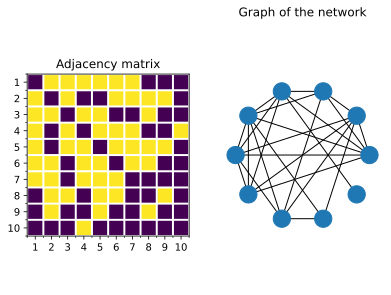

In [12]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

fig = network_graph.plot_graph()


We now create the multi-channel signal $\mathbf{y}$
measured at the nodes and the global signal $\mathbf{d}.$

Each node measures blocks of 10000 samples to estimate the correlation matrices.

We choose the number of filters $Q$ (i.e., the number of columns of
$X$) to be equal to 5.

In [14]:
# Number of samples of the signals
nb_samples = 10000

# Number of filters of X
nb_filters = 5

mmse_inputs = mmse_generate_synthetic_inputs(nb_samples=nb_samples, nb_sensors=network_graph.nb_sensors_total, rng=rng, nb_sources=nb_filters)

The matrix `Y` contains in its columns time samples of $\mathbf{y}$:
$Y = [\mathbf{y}(1);\dots;\mathbf{y}(10000)]$.

When solving the MMSE problem in the DASF setting, we need to use a centralized solver to
solve the local problems created at each different node, where each node solves a parameterized
version of the original problem. The solver we use is **`MMSEProblem`**`.solve` which solves:

$\text{min}_X\; \mathbb{E}[||\mathbf{g}_1(t)-X^T\mathbf{y}_1(t)||^2].$

Comparing it with problem $P$, we see that we have $\mathbf{y}_1=\mathbf{y}$ and
$\mathbf{g}_1=\mathbf{d}$.

The inputs of the problem are stored in the class **`ProblemInputs`** (see documentation for
more information).

In the distributed setting, each node $q$ will solve a parameterized version of the problem $P$
given by:

$\text{min}_{\widetilde{X}_q}\; \mathbb{E}[||\mathbf{d}(t)-\widetilde{X}_q^TC_q^T\mathbf{y}(t)||^2].$

Therefore, in `ls_solver`, we take $\mathbf{y}_1=C_q^T\mathbf{y}$ and
$\mathbf{g}_1=\mathbf{d}$.

The parameters of the problem are stored in the dictionary `prob_params` (see documentation for
more information):

The optimal filter $X^*$ is estimated using the centralized solver **`MMSEProblem`**`.solve` taking
as input `mmse_inputs`.

In [74]:
mmse_problem = MMSEProblem(nb_filters=nb_filters)
X_star = mmse_problem.solve(problem_inputs=mmse_inputs)
f_star = mmse_problem.evaluate_objective(X_star, problem_inputs=mmse_inputs)

In [61]:
if mmse_inputs.fused_constants is not None:
    for constants in mmse_inputs.fused_constants:
        assert(np.size(constants, 0) == network_graph.nb_sensors_total)

In [65]:
for (index, signal) in enumerate(mmse_inputs.fused_data):
    assert(np.size(signal, 0) == network_graph.nb_sensors_total)
    print(index)

0


For the distributed context, we take the previously created network, and choose a randomly
generated sequence as the updating path, i.e., the order in which the nodes take turns
in solving their local problem.

We also fix the number of iterations of the DASF algorithm to be equal to 100.

In [9]:
prob_params['graph_adj'] = graph_adj

update_path = rng.permutation(range(nbnodes))
prob_params['update_path'] = update_path

nbiter = 500
conv = {'nbiter': nbiter}

We also provide $X^*$ to compare the estimation we get from the DASF algorithm to the optimal
value.

In [10]:
prob_params['X_star'] = X_star
prob_params['compare_opt'] = True

Finally, the LS problem is solved in a distributed setting using the DASF framework:

In [11]:
X_est, norm_diff, norm_err, f_seq = dasf(prob_params, data, ls.ls_solver,
                                             conv, solver_params, prob_eval=ls.ls_eval, prob_select_sol=None)

Let us look at the plot of the normalized error $\frac{||X^i-X^*||_F^2}{||X^*||_F^2}$:

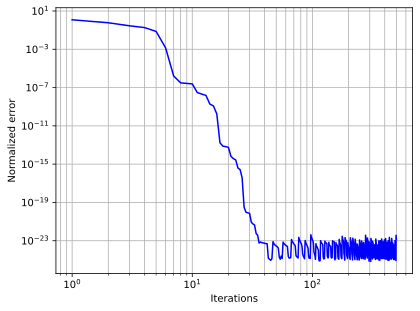

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.loglog(range(1, nbiter + 1), norm_err, color='b')
ax.set_xlabel('Iterations')
ax.set_ylabel('Normalized error')
ax.grid(True, which='both')
plt.show()

Let us also apply the DASF algorithm again, this time using a gradient-descent based solver:

In [13]:
solver_params = {'tol_X': 1e-8, 'maxiter': 10, 'lr': 0.03}
X_est, norm_diff, norm_err, f_seq = dasf(prob_params, data, ls.ls_solver_gd,
                                             conv, solver_params, prob_eval=ls.ls_eval, prob_select_sol=None)

Let us look at the plot of the normalized error $\frac{||X^i-X^*||_F^2}{||X^*||_F^2}$:

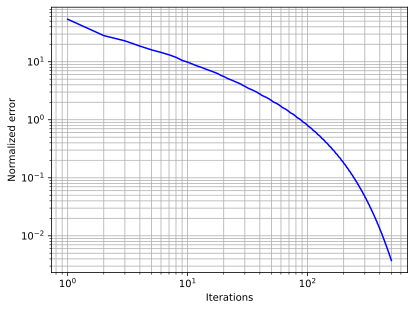

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.loglog(range(1, nbiter + 1), norm_err, color='b')
ax.set_xlabel('Iterations')
ax.set_ylabel('Normalized error')
ax.grid(True, which='both')
plt.show()